### Text Classification 2
Using Kaggle data sets to experiment with text classification to gain experience with deep learning model variations and embeddings. I chose to use the same data set as the previous text classification assignment. The data set classifies tweets based on their sentiment related to COVID-19 and the pandemic.

In [103]:
import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import datasets, layers, models
from sklearn.preprocessing import LabelEncoder

### Looking at the data we're working with
The sentiment can range from extremely negative to extremely positive.

In [104]:
# read in data
data_test = pd.read_csv('data/Corona_NLP_test.csv', header=0, usecols=[4,5], encoding='latin-1')
data_train = pd.read_csv('data/Corona_NLP_train.csv', header=0, usecols=[4,5], encoding='latin-1')[:16000]

# count sentiment
data_test.groupby(['Sentiment'])['Sentiment'].count()
data_train.groupby(['Sentiment'])['Sentiment'].count()

Sentiment
Extremely Negative    2464
Extremely Positive    2423
Negative              4014
Neutral               2813
Positive              4286
Name: Sentiment, dtype: int64

utilizing seaborn, a data visualization library in Python, to create a graph that shows the distribution of the target classes

<Axes: xlabel='Sentiment', ylabel='count'>

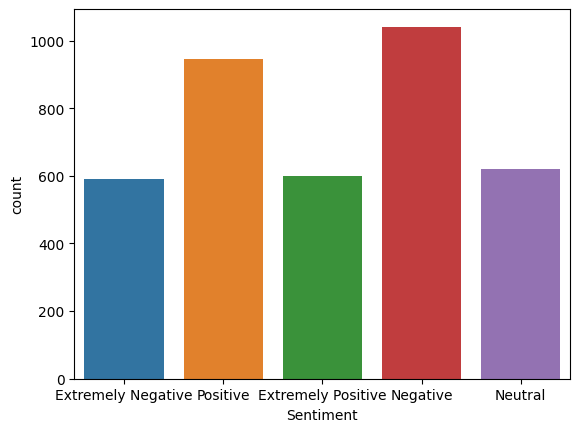

In [105]:
import seaborn as sb
sb.countplot(x = data_test['Sentiment'])

<Axes: xlabel='Sentiment', ylabel='count'>

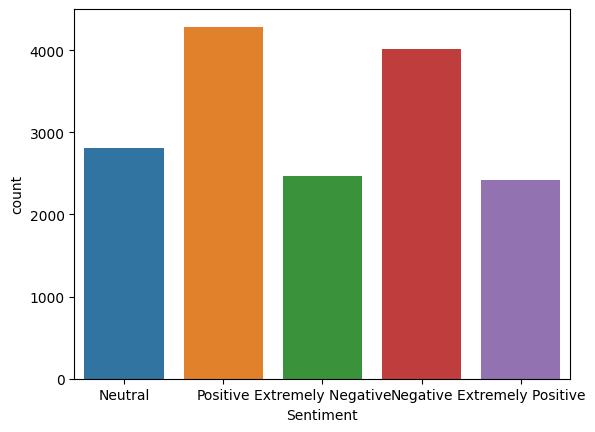

In [106]:
sb.countplot(x = data_train['Sentiment'])

### Vectorizing the tweets

In [107]:
# set up X and Y
num_labels = 5
vocab_size = 25000
batch_size = 100

# fit tokenizer on training data
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data_train['OriginalTweet'])

x_train = tokenizer.texts_to_matrix(data_train['OriginalTweet'], mode='tfidf')
x_test = tokenizer.texts_to_matrix(data_test['OriginalTweet'], mode='tfidf')

encoder = LabelEncoder()
encoder.fit(data_train['Sentiment'])

y_train = encoder.transform(data_train['Sentiment'])
y_test = encoder.transform(data_test['Sentiment'])

# print shapes
print("Train Shapes: ", x_train.shape, y_train.shape)
print("Test Shapes: ", x_test.shape, y_test.shape)
print("Test First Ten Labels: ", y_test[:10])

from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, num_classes = None)
y_test = to_categorical(y_test, num_classes = None)

Train Shapes:  (16000, 25000) (16000,)
Test Shapes:  (3798, 25000) (3798,)
Test First Ten Labels:  [0 4 1 2 3 3 4 3 0 1]


### Sequential Model

In [108]:
# build model
sequential_model = models.Sequential()
sequential_model.add(layers.Dense(24, input_dim = vocab_size, kernel_initializer='normal', activation='relu'))
sequential_model.add(layers.Dropout(0.35))
sequential_model.add(layers.Dense(12, kernel_initializer='normal', activation='relu'))
sequential_model.add(layers.Dropout(0.35))
sequential_model.add(layers.Dense(5, kernel_initializer='normal', activation='softmax'))

In [109]:
# summary of model
sequential_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_52 (Dense)            (None, 24)                600024    
                                                                 
 dropout_22 (Dropout)        (None, 24)                0         
                                                                 
 dense_53 (Dense)            (None, 12)                300       
                                                                 
 dropout_23 (Dropout)        (None, 12)                0         
                                                                 
 dense_54 (Dense)            (None, 5)                 65        
                                                                 
Total params: 600,389
Trainable params: 600,389
Non-trainable params: 0
_________________________________________________________________


In [110]:
# compile model
sequential_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
history = sequential_model.fit(x_train, y_train, 
    epochs = 10, 
    batch_size = batch_size, 
    verbose = 1, 
    validation_split = 0.1)

Epoch 1/10
144/144 [==============================] - 3s 20ms/step - loss: 1.5831 - accuracy: 0.2614 - val_loss: 1.5660 - val_accuracy: 0.2862
Epoch 2/10
144/144 [==============================] - 3s 19ms/step - loss: 1.4418 - accuracy: 0.3501 - val_loss: 1.2919 - val_accuracy: 0.4594
Epoch 3/10
144/144 [==============================] - 3s 18ms/step - loss: 1.1255 - accuracy: 0.5366 - val_loss: 1.1271 - val_accuracy: 0.5400
Epoch 4/10
144/144 [==============================] - 2s 17ms/step - loss: 0.8712 - accuracy: 0.6538 - val_loss: 1.1142 - val_accuracy: 0.5412
Epoch 5/10
144/144 [==============================] - 3s 18ms/step - loss: 0.7152 - accuracy: 0.7281 - val_loss: 1.1412 - val_accuracy: 0.5512
Epoch 6/10
144/144 [==============================] - 3s 18ms/step - loss: 0.6089 - accuracy: 0.7697 - val_loss: 1.2252 - val_accuracy: 0.5512
Epoch 7/10
144/144 [==============================] - 3s 18ms/step - loss: 0.5150 - accuracy: 0.8147 - val_loss: 1.3434 - val_accuracy: 0.5437

In [111]:
# evaluate model
score = sequential_model.evaluate(x_test, y_test, batch_size = batch_size, verbose = 1)
print("Accuracy: ", score[1])

38/38 [==============================] - 0s 9ms/step - loss: 1.8557 - accuracy: 0.5403
Accuracy:  0.5402843356132507


### GRU (RNN) Architecture
Training Gated Recurrent Unit (GRU) and using one-hot encoding to vectorize the words of each tweet.

In [112]:
from tensorflow import keras

LSTM_VOCAB_SIZE = 500

maxlen = 500
batch_size = 32

encoder = LabelEncoder()
encoder.fit(data_train['Sentiment'])

y_train = encoder.transform(data_train['Sentiment'])
y_test = encoder.transform(data_test['Sentiment'])

encoder = keras.layers.TextVectorization(max_tokens=LSTM_VOCAB_SIZE)
encoder.adapt(data_train['OriginalTweet'])

x_train = encoder(data_train['OriginalTweet'])
x_test = encoder(data_test['OriginalTweet'])

x_train = tf.keras.utils.to_categorical(x_train, num_classes=LSTM_VOCAB_SIZE)
x_test = tf.keras.utils.to_categorical(x_test, num_classes=LSTM_VOCAB_SIZE)

from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes=None)
y_test = to_categorical(y_test, num_classes=None)


In [113]:
gru_model = keras.Sequential()
gru_model.add(layers.Bidirectional(layers.GRU(48, input_dim=LSTM_VOCAB_SIZE)))
gru_model.add(layers.Dense(10, activation='relu'))
gru_model.add(layers.Dense(5, activation='softmax'))

In [114]:
# compile model
gru_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# train model
history = gru_model.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.1)

Epoch 1/10
450/450 [==============================] - 71s 152ms/step - loss: 1.5447 - accuracy: 0.2872 - val_loss: 1.4231 - val_accuracy: 0.3606
Epoch 2/10
450/450 [==============================] - 68s 150ms/step - loss: 1.3003 - accuracy: 0.4402 - val_loss: 1.2332 - val_accuracy: 0.4812
Epoch 3/10
450/450 [==============================] - 67s 150ms/step - loss: 1.2042 - accuracy: 0.4878 - val_loss: 1.2017 - val_accuracy: 0.5125
Epoch 4/10
450/450 [==============================] - 67s 149ms/step - loss: 1.1743 - accuracy: 0.5111 - val_loss: 1.2015 - val_accuracy: 0.5056
Epoch 5/10
450/450 [==============================] - 67s 150ms/step - loss: 1.1480 - accuracy: 0.5202 - val_loss: 1.1976 - val_accuracy: 0.5019
Epoch 6/10
450/450 [==============================] - 67s 149ms/step - loss: 1.1295 - accuracy: 0.5319 - val_loss: 1.1996 - val_accuracy: 0.5019
Epoch 7/10
450/450 [==============================] - 67s 149ms/step - loss: 1.1056 - accuracy: 0.5454 - val_loss: 1.2123 - val_ac

In [116]:
gru_model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirectio  (None, 96)               158400    
 nal)                                                            
                                                                 
 dense_55 (Dense)            (None, 10)                970       
                                                                 
 dense_56 (Dense)            (None, 5)                 55        
                                                                 
Total params: 159,425
Trainable params: 159,425
Non-trainable params: 0
_________________________________________________________________


In [115]:
# evaluate
score = gru_model.evaluate(x_test, y_test, batch_size = batch_size, verbose = 1)
print("Accuracy: ", score[1])

119/119 [==============================] - 12s 90ms/step - loss: 1.2992 - accuracy: 0.4684
Accuracy:  0.4684044122695923


### Trying to apply an embedding layer to the GRU model
An embedding is a vector of floating-point values of a predetermined length.

In [117]:
from tensorflow import keras

LSTM_VOCAB_SIZE = 10000

maxlen = 500
batch_size = 32

encoder = LabelEncoder()
encoder.fit(data_train['Sentiment'])

y_train = encoder.transform(data_train['Sentiment'])
y_test = encoder.transform(data_test['Sentiment'])

encoder = keras.layers.TextVectorization(max_tokens=LSTM_VOCAB_SIZE)
encoder.adapt(data_train['OriginalTweet'])

x_train = encoder(data_train['OriginalTweet'])
x_test = encoder(data_test['OriginalTweet'])

from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, num_classes=None)
y_test = to_categorical(y_test, num_classes=None)

In [118]:
gru_model = keras.Sequential()
gru_model.add(layers.Embedding(input_dim=LSTM_VOCAB_SIZE, output_dim=64))
gru_model.add(layers.Bidirectional(layers.GRU(64, input_dim=LSTM_VOCAB_SIZE)))
gru_model.add(layers.Dense(10, activation='relu'))
gru_model.add(layers.Dense(5, activation='softmax'))

In [119]:
gru_model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 64)          640000    
                                                                 
 bidirectional_10 (Bidirecti  (None, 128)              49920     
 onal)                                                           
                                                                 
 dense_57 (Dense)            (None, 10)                1290      
                                                                 
 dense_58 (Dense)            (None, 5)                 55        
                                                                 
Total params: 691,265
Trainable params: 691,265
Non-trainable params: 0
_________________________________________________________________


In [120]:
# compile model
gru_model.compile(loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

# train model
history = gru_model.fit(x_train, y_train,
    batch_size=batch_size,
    epochs=10,
    verbose=1,
    validation_split=0.1)

Epoch 1/10
450/450 [==============================] - 22s 43ms/step - loss: 1.4488 - accuracy: 0.3444 - val_loss: 1.1276 - val_accuracy: 0.5406
Epoch 2/10
450/450 [==============================] - 19s 42ms/step - loss: 0.9111 - accuracy: 0.6391 - val_loss: 0.8667 - val_accuracy: 0.6731
Epoch 3/10
450/450 [==============================] - 19s 42ms/step - loss: 0.6408 - accuracy: 0.7702 - val_loss: 0.8591 - val_accuracy: 0.6806
Epoch 4/10
450/450 [==============================] - 19s 42ms/step - loss: 0.4865 - accuracy: 0.8351 - val_loss: 0.9220 - val_accuracy: 0.6681
Epoch 5/10
450/450 [==============================] - 19s 43ms/step - loss: 0.3716 - accuracy: 0.8778 - val_loss: 1.0020 - val_accuracy: 0.6731
Epoch 6/10
450/450 [==============================] - 20s 44ms/step - loss: 0.2882 - accuracy: 0.9092 - val_loss: 1.1277 - val_accuracy: 0.6519
Epoch 7/10
450/450 [==============================] - 20s 44ms/step - loss: 0.2259 - accuracy: 0.9308 - val_loss: 1.2805 - val_accuracy:

In [121]:
score = gru_model.evaluate(x_test, y_test, batch_size = batch_size, verbose = 1)
print("Accuracy: ", score[1])

119/119 [==============================] - 2s 13ms/step - loss: 1.8268 - accuracy: 0.6056
Accuracy:  0.6055818796157837


Sequential model takes a shorter amount of time to train compared to RNN. When we add the embedding layer to the GRU model, the accuracy increases and the amount of time to train shortens. The embedding representations are dense compared to sparse one-hot matrix representations, which gives the best accuracy score of 60.6%.